In [1]:
!pip install scikit-learn==1.3.2 lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [4]:
rice_df = pd.read_excel('/content/rice_w2vec_4mer_dataset.xlsx')

In [25]:
maize_df = pd.read_excel('maize_w2vec_4mer_dataset.xlsx')

In [26]:
df = rice_df._append(maize_df, ignore_index = True)

In [27]:
df_drought = df.query('stress == "-" or stress == "drought"').replace('-', 0).replace('drought', 1)

In [28]:
df_drought

,circName,circID,gene,isoform,stress,tissue,chr,start,end,strand,...,wc_4mer_247,wc_4mer_248,wc_4mer_249,wc_4mer_250,wc_4mer_251,wc_4mer_252,wc_4mer_253,wc_4mer_254,wc_4mer_255,wc_4mer_256
0,osa-circ1-OS01T0723400,1:30167620-30167771_+,OS01T0723400,OS01T0723400-01,0,multipleTissue,1,30167620,30167771,+,...,0.23,-13.99,4.97,-10.46,5.52,5.79,-4.05,16.67,11.18,-4.66
1,osa-circ2-OS03T0223400,3:6461672-6462146_-,OS03T0223400,OS03T0223400-01,0,multipleTissue,3,6461672,6462146,0,...,134.44,10.04,-8.81,46.56,-58.96,55.19,37.83,25.29,23.79,-36.15
2,osa-circ3-OS11T0210300,11:5715883-5716030_-,OS11T0210300,OS11T0210300-02,0,multipleTissue,11,5715883,5716030,0,...,-56.18,20.78,26.55,-24.83,1.67,21.04,-22.60,53.24,3.81,-16.08
3,osa-circ4-OS02T0200900,2:5631023-5631244_-,OS02T0200900,OS02T0200900-02,0,multipleTissue,2,5631023,5631244,0,...,106.00,-42.11,25.71,19.21,-53.58,31.87,1.50,37.27,9.68,-10.91
4,osa-circ5-OS05T0494800,5:24302336-24302448_+,OS05T0494800,OS05T0494800-01,0,multipleTissue,5,24302336,24302448,+,...,-37.51,35.68,28.13,-5.52,57.73,-5.13,-5.23,-24.71,25.60,3.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101828,zma-circ38781--,10:96969742-96969888_-,0,0,0,root,10,96969742,96969888,0,...,14.08,4.12,28.43,-0.91,14.40,-33.52,22.70,40.30,18.43,5.95
101829,zma-circ38782--,4:244809483-244809674_-,0,0,0,leaf,4,244809483,244809674,0,...,-11.29,-32.89,36.48,-14.28,-8.71,3.45,12.91,-27.76,0.79,46.59
101830,zma-circ38783--,1:38916899-38917325_+,0,0,0,shoot,1,38916899,38917325,+,...,34.13,-24.30,44.81,-10.68,19.01,-57.52,66.19,29.09,25.61,9.24
101831,zma-circ38784--,1:205166872-205167268_-,0,0,0,root,1,205166872,205167268,0,...,130.21,-118.00,114.66,-29.13,53.28,-74.42,6.68,-20.77,-44.85,112.21


### Training and test models

In [29]:
# Define X and y (target) variables
X = df_drought.drop(['circName', 'stress', 'tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)
y = df_drought['stress']

In [30]:
X.head(2)

,wc_4mer_1,wc_4mer_2,wc_4mer_3,wc_4mer_4,wc_4mer_5,wc_4mer_6,wc_4mer_7,wc_4mer_8,wc_4mer_9,wc_4mer_10,...,wc_4mer_247,wc_4mer_248,wc_4mer_249,wc_4mer_250,wc_4mer_251,wc_4mer_252,wc_4mer_253,wc_4mer_254,wc_4mer_255,wc_4mer_256
0,-7.03,3.89,-3.41,19.99,-7.58,14.46,5.79,4.07,-18.32,-10.78,...,0.23,-13.99,4.97,-10.46,5.52,5.79,-4.05,16.67,11.18,-4.66
1,-11.00,-10.42,16.46,-88.31,1.41,-58.91,52.35,6.18,-41.47,-64.47,...,134.44,10.04,-8.81,46.56,-58.96,55.19,37.83,25.29,23.79,-36.15


In [31]:
y.value_counts()

,count
stress,
0,70996
1,12030


In [32]:
ros = RandomUnderSampler(sampling_strategy=1)

X_res, y_res = ros.fit_resample(X, y)

In [33]:
y_res.value_counts()

,count
stress,
0,12030
1,12030


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=204)

In [35]:
clf = LazyClassifier(predictions=True, random_state=204)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████▋| 28/29 [13:22<00:28, 28.17s/it]

[LightGBM] [Info] Number of positive: 9567, number of negative: 9681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 19248, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497039 -> initscore=-0.011846
[LightGBM] [Info] Start training from score -0.011846


100%|██████████| 29/29 [13:31<00:00, 27.97s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.82,0.82,0.82,0.82,10.25
QuadraticDiscriminantAnalysis,0.82,0.82,0.82,0.82,1.29
RandomForestClassifier,0.82,0.82,0.82,0.82,70.65
LGBMClassifier,0.82,0.82,0.82,0.82,8.30
NuSVC,0.82,0.81,0.81,0.81,151.65
SVC,0.81,0.81,0.81,0.81,122.38
XGBClassifier,0.81,0.81,0.81,0.81,15.28
AdaBoostClassifier,0.81,0.81,0.81,0.81,66.15
LogisticRegression,0.81,0.81,0.81,0.80,2.28


In [36]:
model_lgb = lgb.LGBMClassifier(random_state=204)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)

[LightGBM] [Info] Number of positive: 9567, number of negative: 9681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 19248, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497039 -> initscore=-0.011846
[LightGBM] [Info] Start training from score -0.011846
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      2349
           1       0.78      0.91      0.84      2463

    accuracy                           0.82      4812
   macro avg       0.83      0.82      0.82      4812
weighted avg       0.83      0.82      0.82      4812



In [37]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=204)
modelrf.fit(X_train, y_train)

y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      2349
           1       0.78      0.91      0.84      2463

    accuracy                           0.82      4812
   macro avg       0.83      0.82      0.82      4812
weighted avg       0.83      0.82      0.82      4812



In [38]:
dump(model_lgb, 'lgb_model_drought_4mer.joblib')
print('LGB - Cold Model created.')

LGB - Cold Model created.


In [39]:
dump(modelrf, 'rf_model_drought_4mer.joblib')
print('RF - Cold Model created.')

RF - Cold Model created.


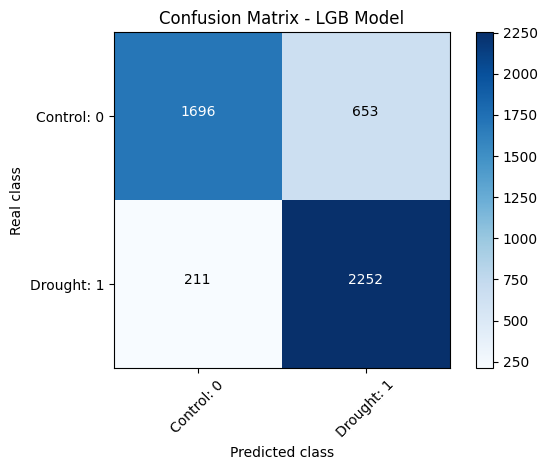

In [40]:
cnf_matrix = confusion_matrix(y_test, y_pred_lgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - LGB Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Drought: 1'])

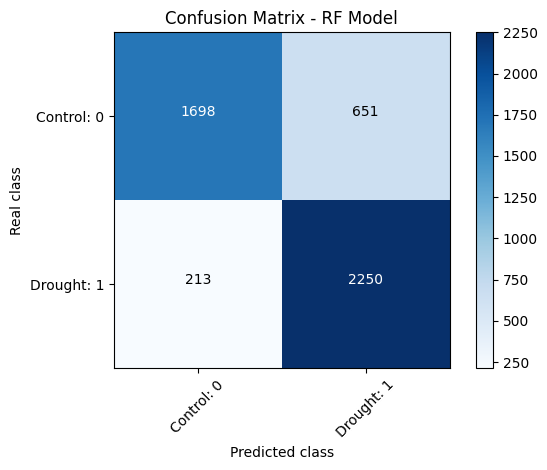

In [41]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - RF Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Drought: 1'])